<a href="https://colab.research.google.com/github/mmmmpf/CovaLib/blob/master/VGG16_based_Deep_Learning_Model_for_Classifying_Chest_X_Rays_of_COVID_19%2C_Pneumonia%2C_and_Healthy_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
# This code will create a machine learning model to identify X-ray images of normal patients or those who have covid-19 or viral pneumonia
# dataset: https://www.kaggle.com/code/kartik2khandelwal/covid-pneumonia-detector-using-vgg16

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os


# Suppress warnings for cleaner output during experimentation (not recommended for production)
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping



In [93]:
my_path="/content/drive/MyDrive/COVID-19_Radiography_Dataset/"

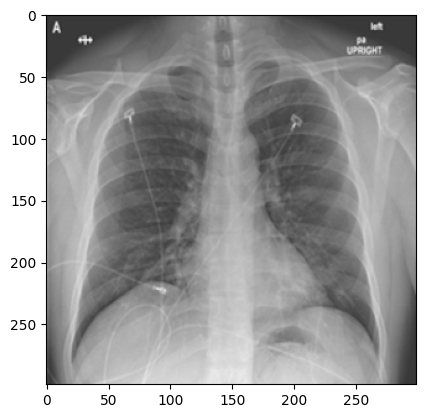

In [94]:
# Define paths to image folders
covid_path = my_path+'COVID/images/'
normal_path = my_path+'Normal/images/'
pneu_path = my_path+'Viral Pneumonia/images/'

# Set random seed for reproducibility
random.seed(42)

# Load and preprocess filenames
filenames = []
categories = []
for folder in [covid_path, normal_path, pneu_path]:
  for filename in random.sample(os.listdir(folder), 800): # load only 800 images per category
    categories.append({covid_path: 2, normal_path: 0,pneu_path: 1}[folder])  # assign category based on path
    filenames.append(os.path.join(folder, filename))

# Create pandas DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Convert category values to strings
df['category'] = df['category'].astype(str)

# Visualize a sample image
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()


In [95]:
# Split data into training, validation, and test sets (stratified)
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42, shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)



In [96]:
# Data augmentation for training data
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generate training and validation data with data augmentation for training set
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=15
)

valid_data_gen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=15
)

# Load pre-trained VGG16 model with weights frozen for feature extraction
baseModel = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in baseModel.layers:
    layer.trainable = False # freeze the base model

# Add custom head for classification
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

# Create final model with pre-trained base and custom head
model = Model(inputs=baseModel.input, outputs=headModel)

# Summarize model architecture
model.summary()


Found 1920 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
    

In [97]:
# Compile model with Adam optimizer, categorical crossentropy loss, and accuracy metric
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback to monitor validation accuracy after 5 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with early stopping
epochs = 50
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs,
                              callbacks=[early_stopping])



Epoch 1/50
128/128 [==============================] - 518s 4s/step - loss: 0.7930 - accuracy: 0.6604 - val_loss: 0.4927 - val_accuracy: 0.8000
Epoch 2/50
128/128 [==============================] - 37s 293ms/step - loss: 0.5693 - accuracy: 0.7781 - val_loss: 0.4064 - val_accuracy: 0.8500
Epoch 3/50
128/128 [==============================] - 37s 290ms/step - loss: 0.4856 - accuracy: 0.8068 - val_loss: 0.3885 - val_accuracy: 0.8417
Epoch 4/50
128/128 [==============================] - 36s 281ms/step - loss: 0.4451 - accuracy: 0.8224 - val_loss: 0.3438 - val_accuracy: 0.8500
Epoch 5/50
128/128 [==============================] - 39s 304ms/step - loss: 0.4145 - accuracy: 0.8380 - val_loss: 0.3285 - val_accuracy: 0.8542
Epoch 6/50
128/128 [==============================] - 40s 312ms/step - loss: 0.3936 - accuracy: 0.8474 - val_loss: 0.3180 - val_accuracy: 0.8708
Epoch 7/50
128/128 [==============================] - 39s 307ms/step - loss: 0.3700 - accuracy: 0.8594 - val_loss: 0.2879 - val_accu

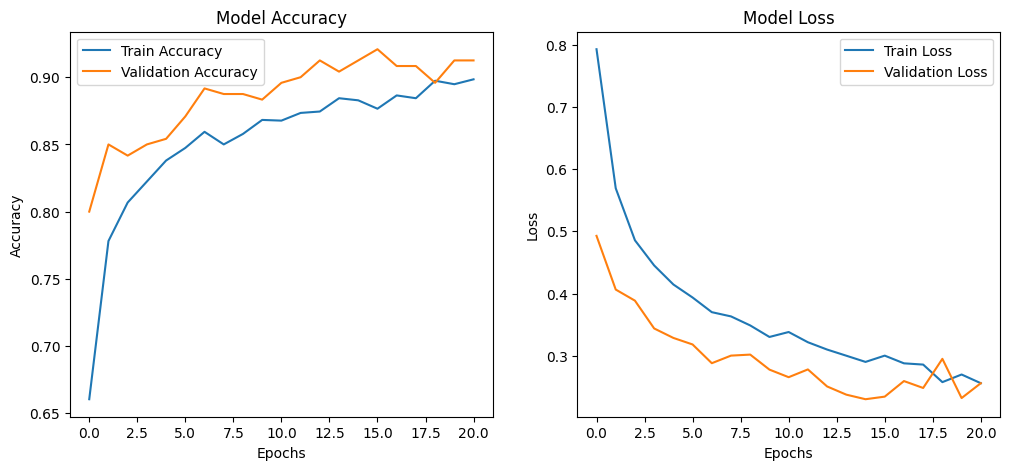

In [98]:
# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

True value is: Normal
1/1 [==============================] - 0s 25ms/step
Prediction is:
Normal


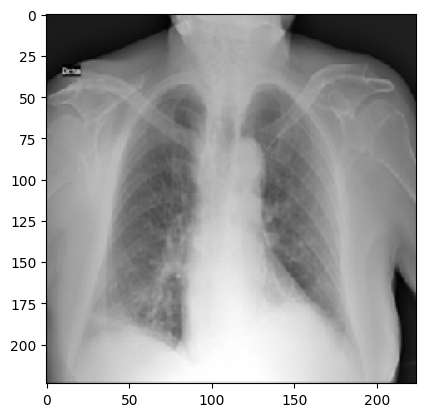

In [106]:
# Make prediction on a test sample
sample = random.choice(test_data['filename'])

# Extract category label from filename
category = sample.split('-')[0]
true_label = ''
if category == 'COVID':
    true_label = 'COVID'
elif category == 'Viral Pneumonia':
    true_label = 'Viral Pneumonia'
else:
    true_label = 'Normal'

print(f'True value is: {true_label}')

# Load and pre-process test image
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

# Predict class probabilities for the test image
result = model.predict(img)
result = np.argmax(result, axis=-1)

print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID +")

# Optionally, visualize the test image
plt.imshow(image)
plt.show()

1/1 [==============================] - 0s 19ms/step
True Category: Normal
Prediction is:
Normal


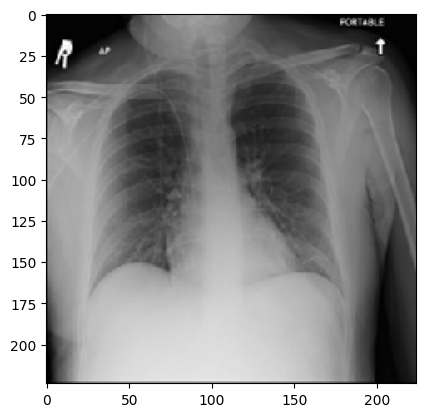

1/1 [==============================] - 0s 18ms/step
True Category: Pneumonia
Prediction is:
Viral Pneumonia


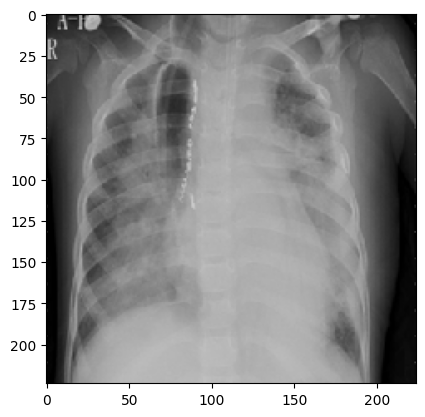

1/1 [==============================] - 0s 18ms/step
True Category: COVID
Prediction is:
COVID +


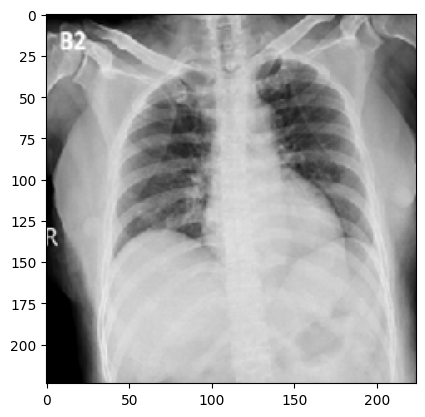

In [109]:
# Make prediction on a test sample from each category
categories = ["Normal", "Pneumonia", "COVID"]

for category, image_df in zip(categories, [test_data[test_data['category']=='0'].sample(1),
                                           test_data[test_data['category']=='1'].sample(1),
                                           test_data[test_data['category']=='2'].sample(1)]):
  # Iterate over image paths in the DataFrame subset (should only be one)
  for image_path in image_df['filename']:
    # Load and preprocess image
    image = load_img(image_path, target_size=(224, 224))
    img = img_to_array(image)
    img = img.reshape((1, 224, 224, 3))

    # Predict class probabilities
    result = model.predict(img)
    result = np.argmax(result, axis=-1)

    print(f"True Category: {category}")
    print('Prediction is:')
    if result == 0:
        print("Normal")
    elif result == 1:
        print("Viral Pneumonia")
    else:
        print("COVID +")

  # Visualize the test image
  plt.imshow(image)
  plt.show()